# load data and do elementary calculations and plots

---

In [1]:
import os
import numpy as np
import dask
import xarray as xr
import xgcm
import xscale
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

import cartopy.crs as ccrs
from cmocean import cm

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(28)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.1.13:53050' processes=34 cores=136>

# 1. Eta
_______


In [5]:
# read Eta outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)

ds = ds.chunk({'face': 1})
#ds = ds.assign_coords(time=iters)
print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=11).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 10311)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=

## Coast and open ocean

### face 5, China coastline

In [6]:
eta = ds['Eta'].isel(face=5, time=8000, i=slice(2500,4320), j=slice(0,2000))

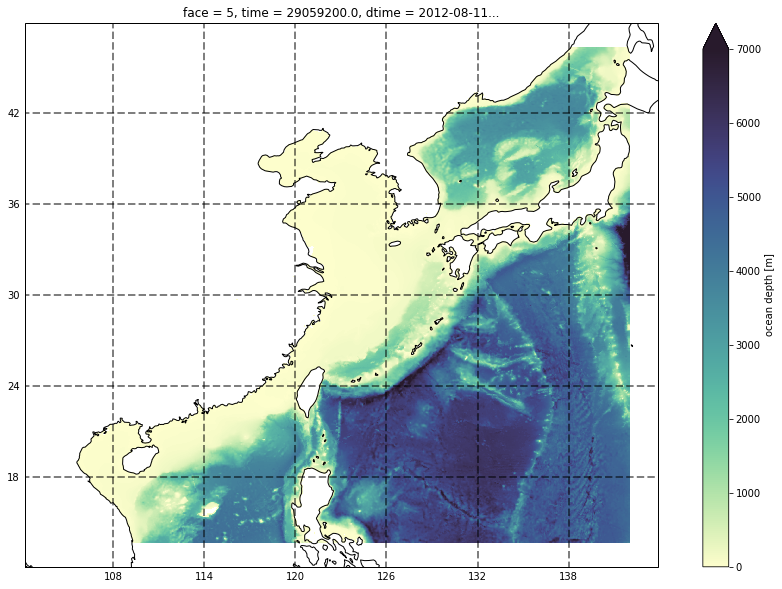

In [12]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

eta.Depth.where(eta.Depth>0).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=7000, cmap = cm.deep)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

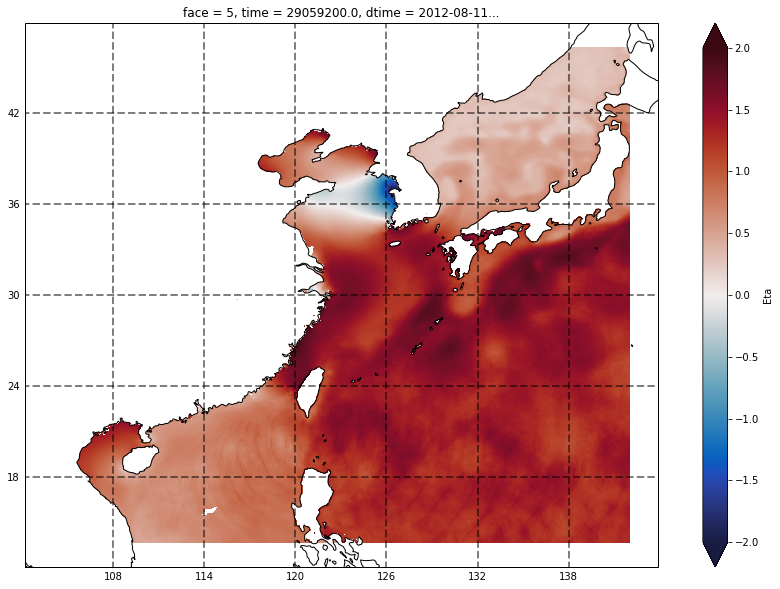

In [13]:
# plot Eta at face 11 and time 8000

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

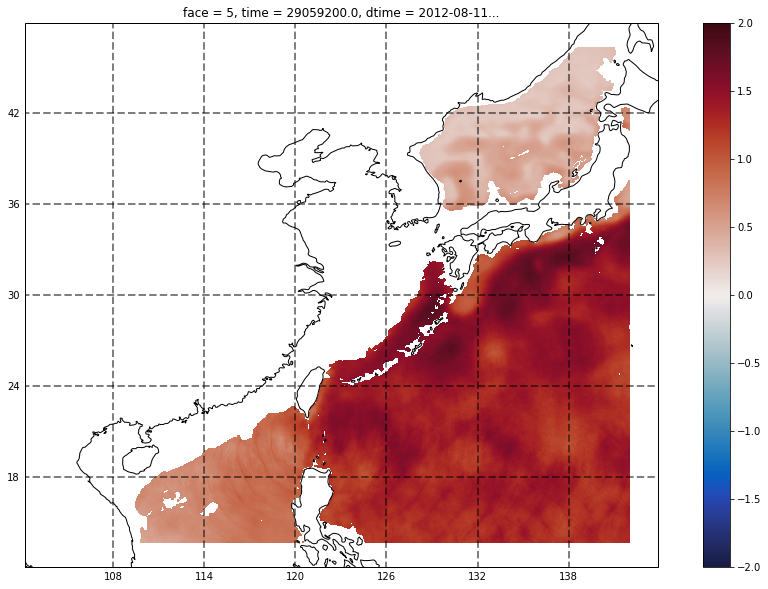

In [10]:
# plot Eta at face 11 and time 8000

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

(eta.where(eta.Depth>500)).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# Face 1, Africa

In [38]:
eta = ds['Eta'].isel(face=1, time=8000)

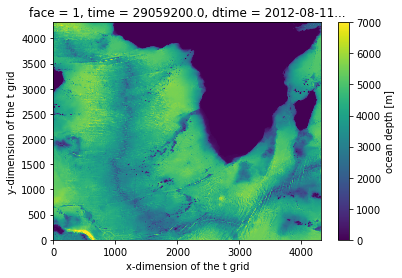

In [39]:
eta.Depth.plot()

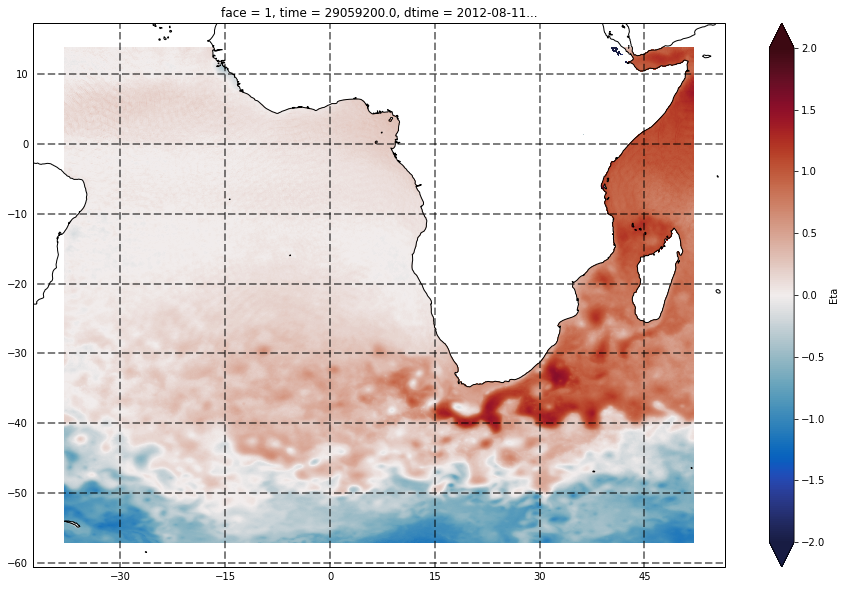

In [42]:

#eta = ds['Eta'].isel(face=1, time=8000)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

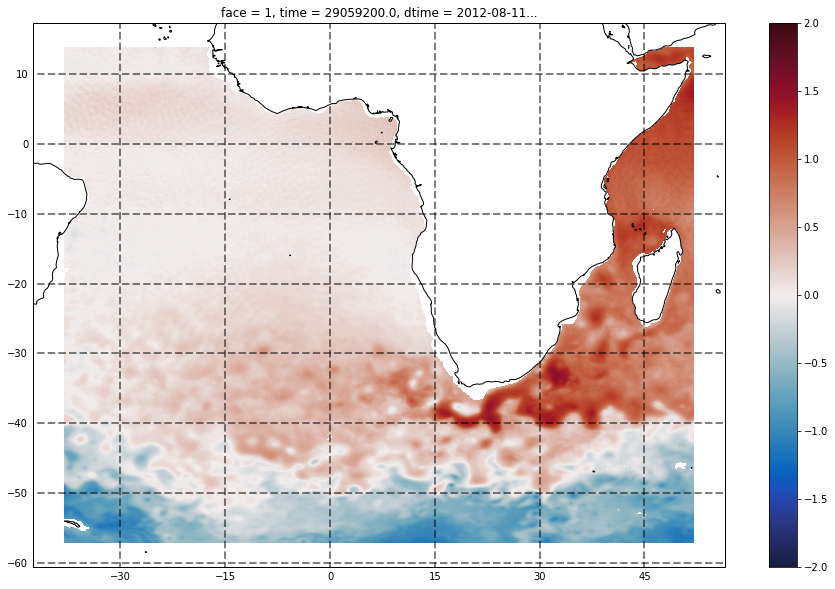

In [46]:
# plot Eta at face 11 and time 8000

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

(eta.where(eta.Depth>500)).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)

#eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

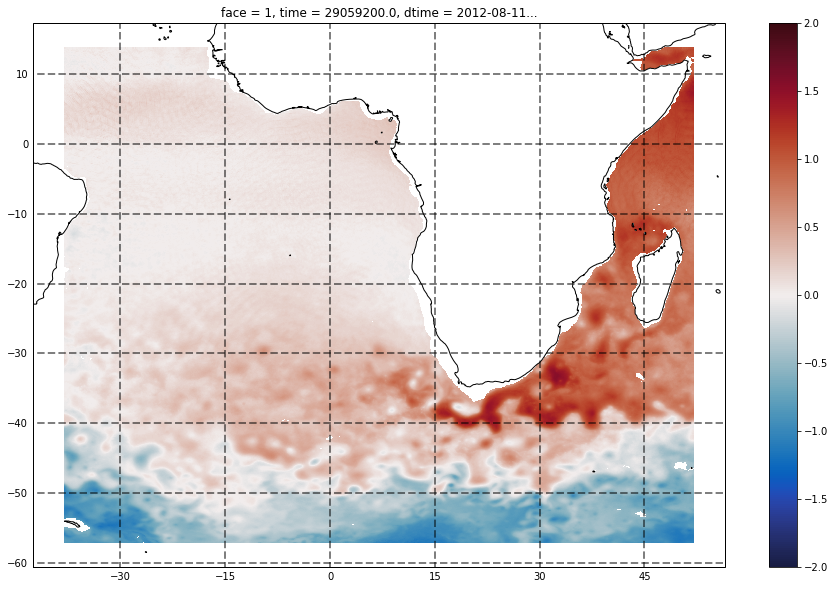

In [47]:
# plot Eta at face 11 and time 8000

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

(eta.where(eta.Depth>1000)).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)

#eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

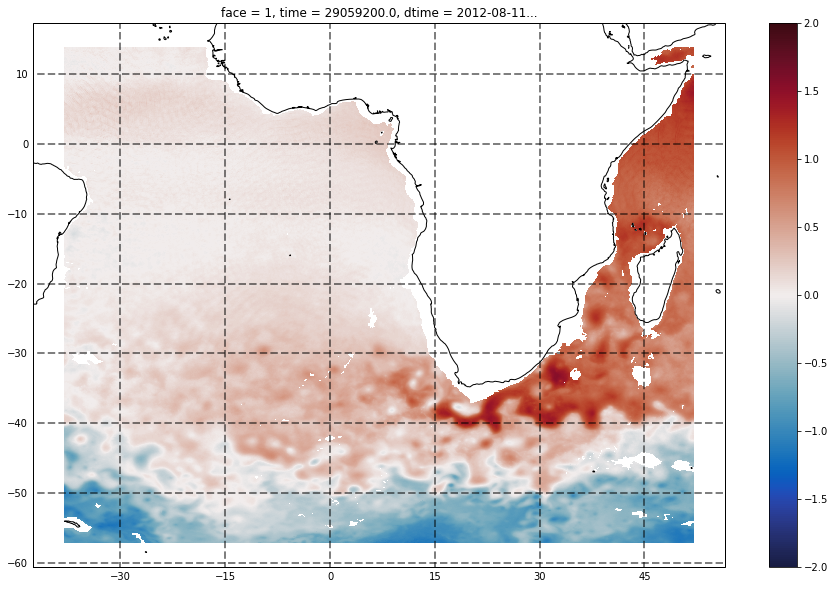

In [48]:
# plot Eta at face 11 and time 8000

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

(eta.where(eta.Depth>2000)).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)

#eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

Text(0,0.5,'Lat')

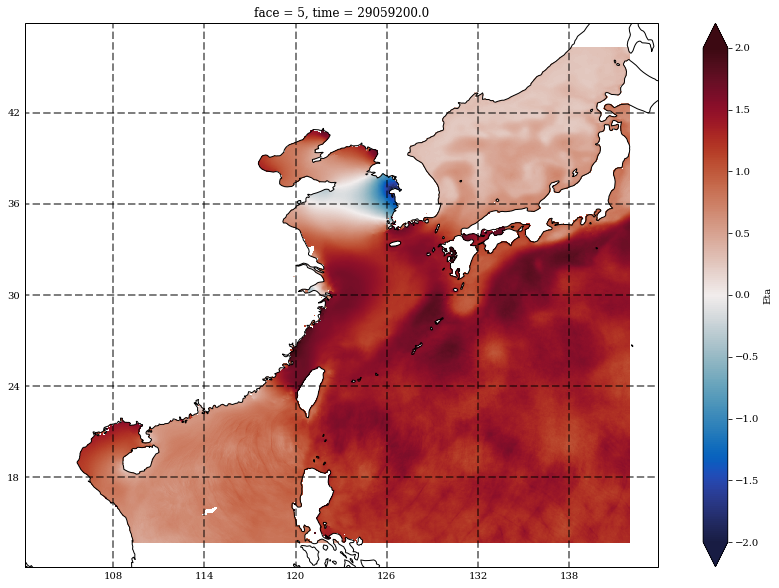

In [7]:
# plot Eta at face 5 and time 8000

eta = ds['Eta'].isel(face=5, time=8000, i=slice(2500,4320), j=slice(0,2000))

plt.rc('font', family='serif')

plt.figure(figsize=(16,10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

#fig = plt.figure(figsize=(16,10))
#ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

#ax.set_title('a sine wave')
plt.xlabel('Lon', fontsize=18)
plt.ylabel('Lat', fontsize=18)

CPU times: user 21.7 s, sys: 896 ms, total: 22.6 s
Wall time: 9min 5s


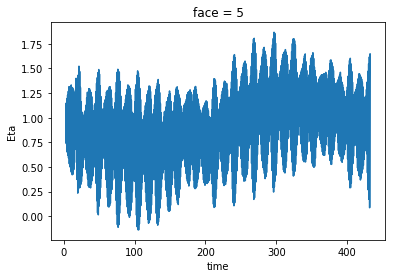

In [7]:
E = ds.Eta
E = E.assign_coords(time=ds.time / 86400.)

%time E.isel(face=5, i=slice(3000,3200), j=slice(100,300)).mean(dim=['i','j']).plot()

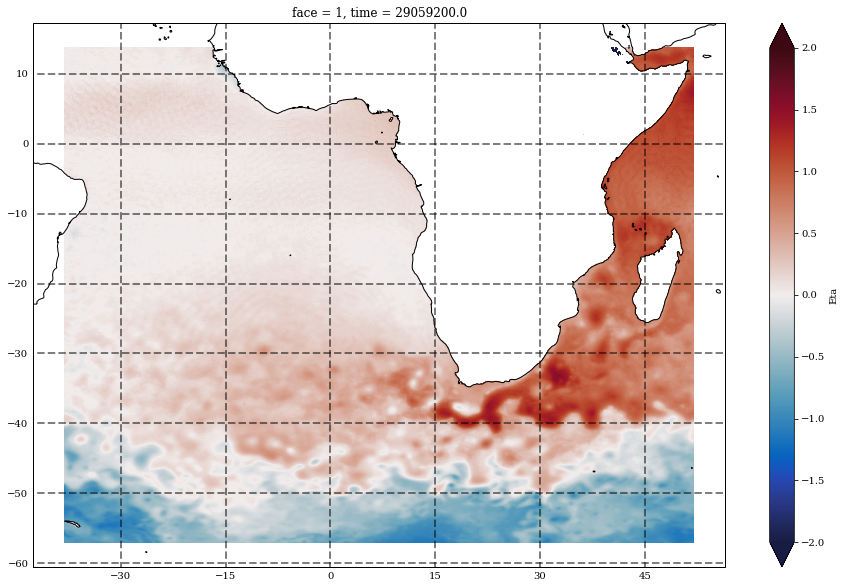

In [9]:
# plot Eta at face 1 and time 8000

eta = ds['Eta'].isel(face=1, time=8000)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

CPU times: user 21.6 s, sys: 836 ms, total: 22.4 s
Wall time: 9min 4s


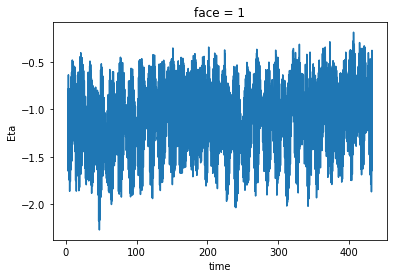

In [8]:
%time E.isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()

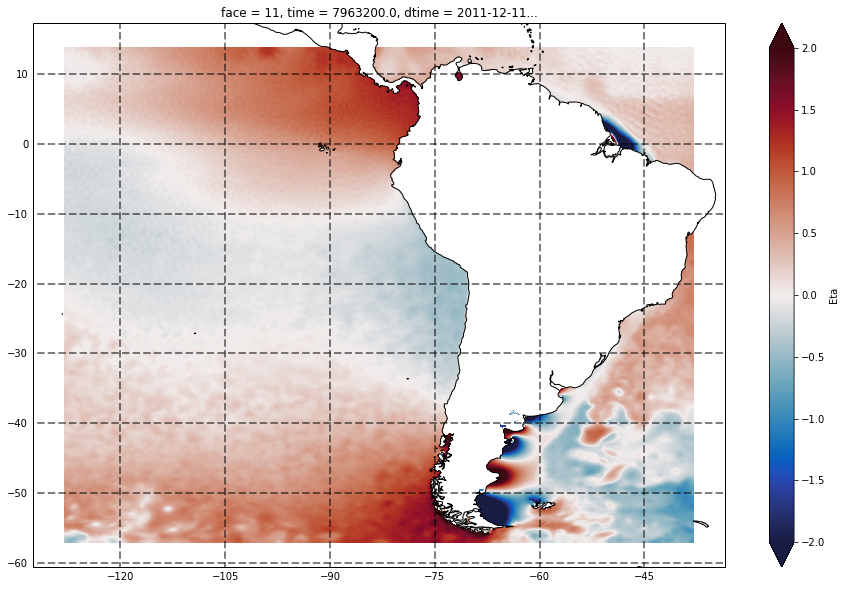

In [65]:
# plot Eta at face 11 and time 8000

eta = ds['Eta'].isel(face=11, time=2140)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

### issue on face 11, time = 2140 (issue resolved 20181226)

In [14]:
eta = ds['Eta'].isel(face=11, time=2140)

In [15]:
print(eta)

<xarray.DataArray 'Eta' (j: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=>f4, chunksize=(4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 11
    XC       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    YC       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    CS       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    SN       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    rA       (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    Depth    (j, i) >f4 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    time     float64 7.963e+06
    dtime    datetime64[ns] dask.array<shape=(), chunksize=()>


In [16]:
eta.mean(dim=['i','j']).compute()

<xarray.DataArray 'Eta' ()>
array(0.209711, dtype=float32)
Coordinates:
    face     int64 11
    time     float64 7.963e+06
    dtime    datetime64[ns] 2011-12-11T04:00:00

In [18]:
E = ds.Eta
E = E.assign_coords(time=ds.time / 86400.)

In [19]:
%time E.isel(face=11, time=2140).mean(dim=['i','j']).compute()

CPU times: user 384 ms, sys: 28 ms, total: 412 ms
Wall time: 4.9 s


<xarray.DataArray 'Eta' ()>
array(0.209711, dtype=float32)
Coordinates:
    face     int64 11
    time     float64 92.17
    dtime    datetime64[ns] 2011-12-11T04:00:00

In [20]:
%time E.isel(face=11, time=2141).mean(dim=['i','j']).compute()

CPU times: user 368 ms, sys: 24 ms, total: 392 ms
Wall time: 5 s


<xarray.DataArray 'Eta' ()>
array(0.220034, dtype=float32)
Coordinates:
    face     int64 11
    time     float64 92.21
    dtime    datetime64[ns] 2011-12-11T05:00:00

In [21]:
%time E.isel(face=11, time=2139).mean(dim=['i','j']).compute()

CPU times: user 236 ms, sys: 16 ms, total: 252 ms
Wall time: 2.87 s


<xarray.DataArray 'Eta' ()>
array(0.224349, dtype=float32)
Coordinates:
    face     int64 11
    time     float64 92.12
    dtime    datetime64[ns] 2011-12-11T03:00:00

CPU times: user 34.6 s, sys: 2.06 s, total: 36.7 s
Wall time: 2min 27s


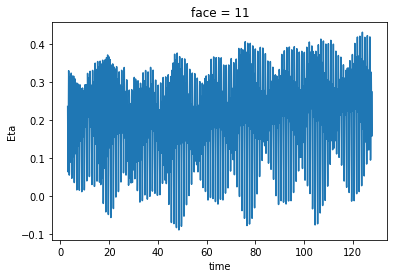

In [22]:
%time E.isel(face=11, time=slice(0,3000)).mean(dim=['i','j']).plot()

In [23]:
%time m1 = E.isel(face=11, time=slice(0,3000)).mean(dim=['i','j']).persist()

CPU times: user 1.2 s, sys: 8 ms, total: 1.21 s
Wall time: 1.2 s


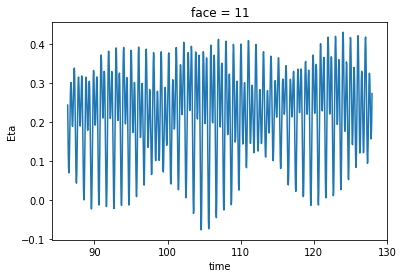

In [24]:
m1.isel(time=slice(2000,3000)).plot()

# 2. SST
________


In [20]:
# read SST outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/SST/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('SST', data_dir, delta_t=25.)

ds = get_compressed_data('SST', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['SST'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SST'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8785)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

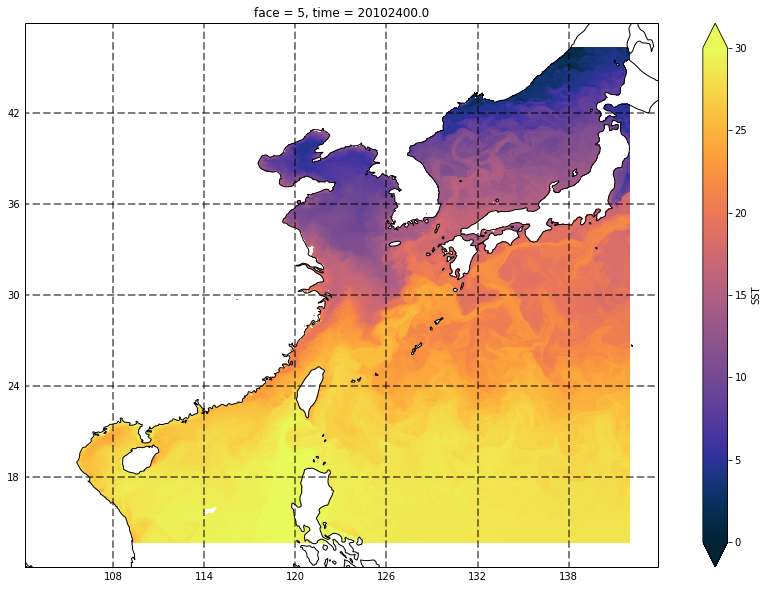

In [12]:
# plot SST at face 5 and time 8000

eta = ds['SST'].isel(face=5, time=4000, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30, cmap = cm.thermal)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')


In [10]:
E = ds.SST
E = E.assign_coords(time_day=ds.time / 86400.)
print(E)

<xarray.DataArray 'SST' (time: 8785, face: 13, j: 4320, i: 4320)>
dask.array<shape=(8785, 13, 4320, 4320), dtype=>f4, chunksize=(1, 1, 4320, 4320)>
Coordinates:
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC        (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC        (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    rA        (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth     (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * time      (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    dtime     (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
    time_day  (time) float64 66.0 66.04 66.08 66.12 66.17 66.21 66.25 66.29 ...


CPU times: user 19.2 s, sys: 740 ms, total: 19.9 s
Wall time: 7min 31s


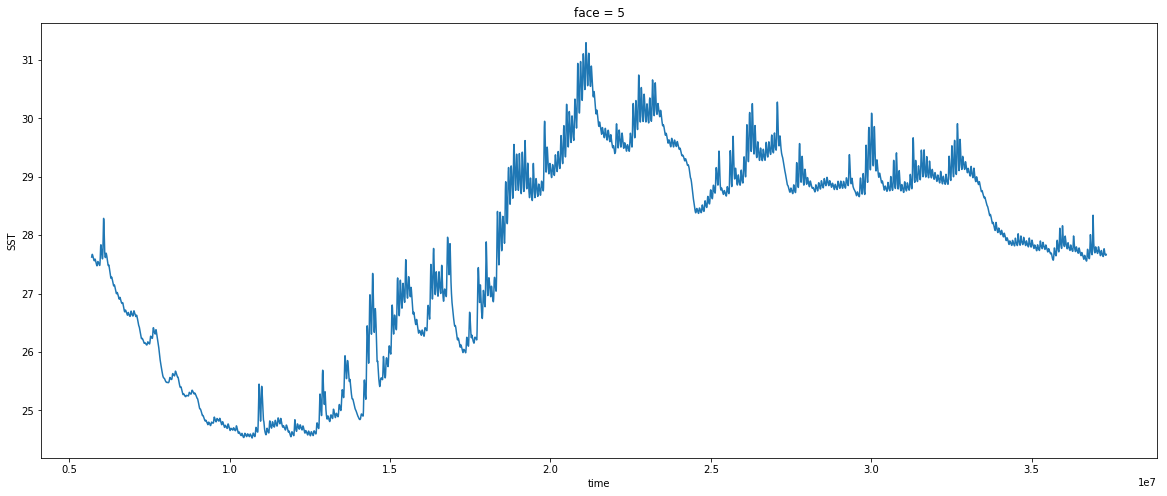

In [13]:

fig, ax = plt.subplots(figsize=(20,8))

#E.isel(face=1, i=slice(0,100), j=slice(0,100), time=slice(0,1000)).mean(dim=['i','j']).plot()
%time E.isel(face=5, i=slice(3000,3200), j=slice(100,300)).mean(dim=['i','j']).plot()

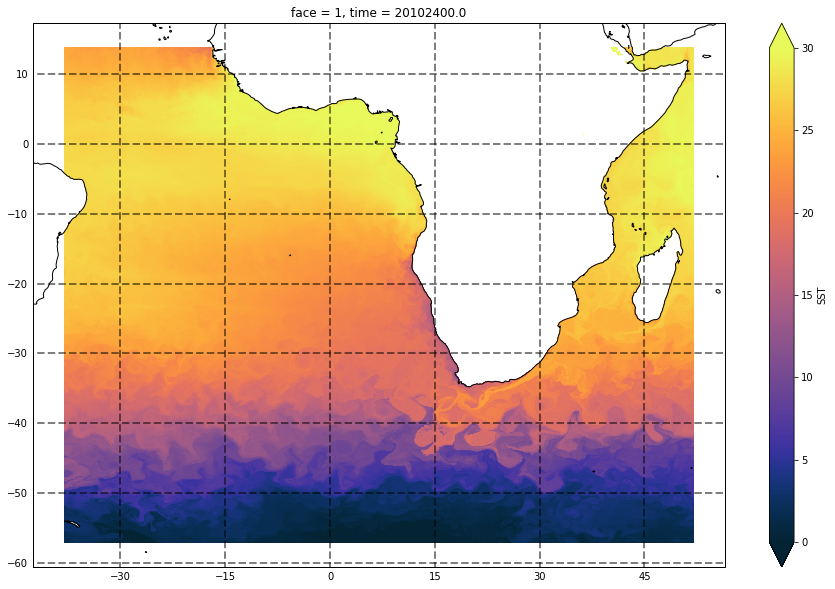

In [14]:
# plot SST at face 1 and time 4000

eta = ds['SST'].isel(face=1, time=4000)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=30, cmap = cm.thermal)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

CPU times: user 19.4 s, sys: 740 ms, total: 20.1 s
Wall time: 7min 32s


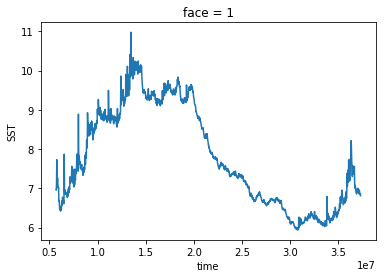

In [14]:
%time E.isel(face=1, i=slice(1000,1100), j=slice(1000,1100)).mean(dim=['i','j']).plot()

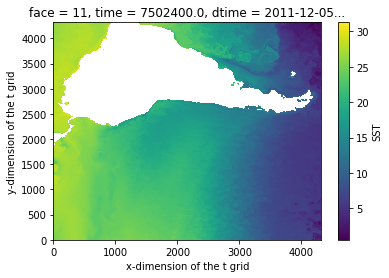

In [21]:
sst = ds['SST'].isel(face=11, time=500).plot()

# 3. SSS

_______

In [15]:
# read SSS outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/SSS/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('SSS', data_dir, delta_t=25.)

ds = get_compressed_data('SSS', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['SSS'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSS'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8785)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

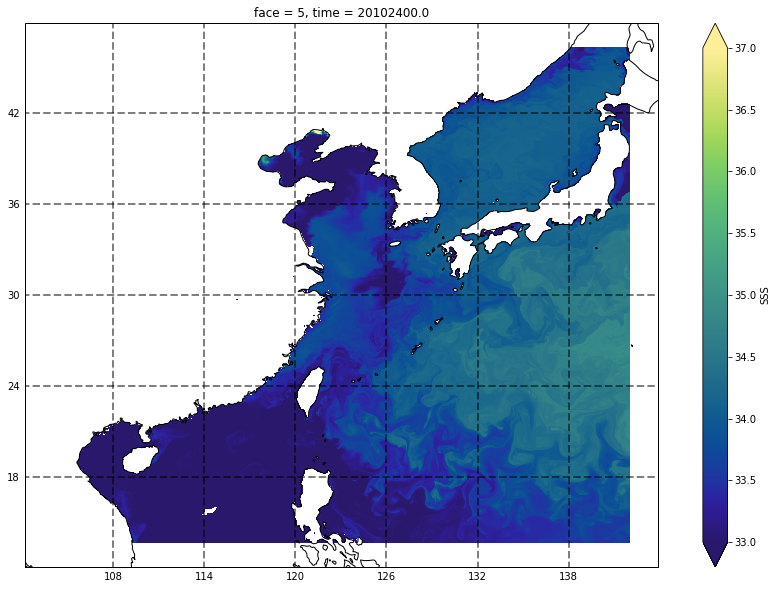

In [17]:
# plot SSS at face 5 and time 4000

eta = ds['SSS'].isel(face=5, time=4000, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

CPU times: user 19.6 s, sys: 776 ms, total: 20.4 s
Wall time: 7min 30s


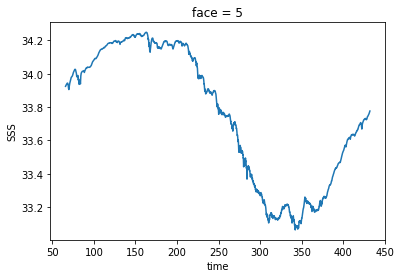

In [16]:
E = ds.SSS
E = E.assign_coords(time=ds.time / 86400.)

%time E.isel(face=5, i=slice(3500,4000), j=slice(250,7500)).mean(dim=['i','j']).plot()

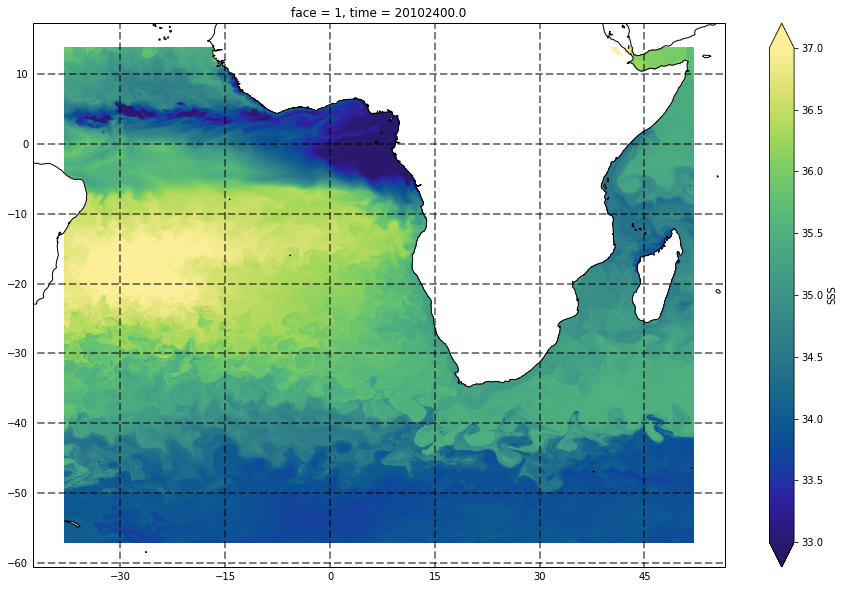

In [19]:
# plot SSS at face 1 and time 4000

eta = ds['SSS'].isel(face=1, time=4000)

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

CPU times: user 19.3 s, sys: 728 ms, total: 20.1 s
Wall time: 7min 27s


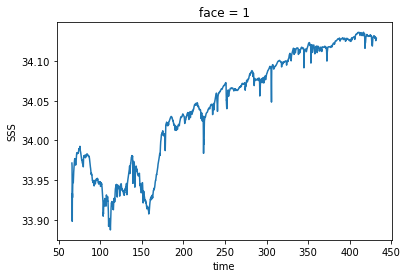

In [17]:
%time E.isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()

# 4. SSU 

______

In [18]:
# read SSU outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/SSU/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('SSU', data_dir, delta_t=25.)

ds = get_compressed_data('SSU', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['SSU'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSU'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8785)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

# 5. SSV

_________

In [20]:
# read SSV outputs using xrray and xmitgcm
data_dir = '/home/datawork-lops-osi/data/mit4320/SSV/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('SSV', data_dir, delta_t=25.)

ds = get_compressed_data('SSV', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['SSV'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSV'].isel(face=1).nbytes / 1e9))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8785)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

---

# Basic statistics

In [25]:
ds['Eta'].isel(face=1, i=0, j=0).mean().compute()

<xarray.DataArray 'Eta' ()>
array(-1.01498, dtype=float32)
Coordinates:
    i        int64 0
    j        int64 0
    face     int64 1
    XC       float32 -37.989582
    YC       float32 -57.001026
    CS       float32 1.0
    SN       float32 6.261379e-13
    rA       float32 1552802.6
    Depth    float32 3047.2024

In [12]:
%time m1 = ds['Eta'].isel(face=11).mean(['time']).persist()

CPU times: user 4.24 s, sys: 92 ms, total: 4.33 s
Wall time: 4.31 s


In [13]:
m1.plot()

KeyboardInterrupt: 

---

# info, shutdown

In [27]:
cluster.scheduler.close()

<Future finished result=None>